# Model Evaluation
## Best ML vs Best DL
### Evaluation & Visualization
### Models
 - Best ML: LightGBM
 - Best DL: Seq2Seq

In [1]:
# Clone GitHub Repository
!git clone https://github.com/sabin74/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform.git


Cloning into 'Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform'...
remote: Enumerating objects: 317, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 317 (delta 51), reused 33 (delta 6), pack-reused 216 (from 1)
Receiving objects: 100% (317/317), 41.70 MiB | 15.97 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Filtering content: 100% (22/22), 348.58 MiB | 14.93 MiB/s, done.


In [2]:
# Import Libraries
import os, gc, json, joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# Set Project Root
os.chdir('/content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform')
print("Current Directory: ", os.getcwd())

Current Directory:  /content/Enterprise-Intelligent-Demand-Forecasting-Decision-Optimization-Platform


In [4]:
MODEL_PATH = Path('models')
REPORT_PATH = Path('data/reports')
REPORT_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
# Import Original Data
train = pd.read_parquet("data/features/train_features.parquet")

train["date"] = pd.to_datetime(train["date"])
train = train.sort_values(["store_nbr", "family", "date"]).reset_index(drop=True)



In [6]:

# Drop lag NaNs
lag_cols = [c for c in train.columns if "lag" in c or "roll" in c]
train = train.dropna(subset=lag_cols).reset_index(drop=True)



In [7]:
# Memory Optimization (reduce memory usage)
def reduce_mem_usage(df, ):
  for col in df.columns:
    if df[col].dtype == "float64":
      df[col] = df[col].astype("float32")
    elif df[col].dtype == "int64":
      df[col] = df[col].astype("int32")
  return df

train = reduce_mem_usage(train)
gc.collect()

0

# Prediction on ML(LightGBM) Model

In [8]:
# Recreate Features
DROP_COLS = ["id", "date", "sales", "sales_log"]
TARGET = "sales_log"

FEATURES = [c for c in train.columns if c not in DROP_COLS]

X_full = train[FEATURES]
y_full = train[TARGET]


In [9]:
# Categorical Features
CAT_COLS = [
    'family',
    'city',
    'state',
    'store_type',
    'holiday_type',
    'locale',
    'locale_name',
    'description'
]

for col in CAT_COLS:
    X_full[col] = X_full[col].astype("category")


In [10]:
import lightgbm as lgb

lgb_model = lgb.Booster(
    model_file="models/lightgbm/baseline_lightgbm.txt"
)

y_pred_lgb_log = lgb_model.predict(
    X_full,
    num_iteration=lgb_model.best_iteration
)

y_true_ml = np.expm1(y_full.values)
y_pred_ml= np.expm1(y_pred_lgb_log)


# Prediction on DL(Seq2Seq) Model

In [11]:
# Load DL Features map and scaler
import json, joblib

with open("models/dl_feature&Scaler/dl_feature_map.json", "r") as f:
    feature_map = json.load(f)

NUMERIC_FEATURES = feature_map["numeric_features"]
CATEGORICAL_FEATURES = feature_map["categorical_features"]
DL_FEATURES = feature_map["dl_features_order"]
category_maps = feature_map["category_maps"]
WINDOW_SIZE = feature_map["window_size"]

scaler = joblib.load("models/seq2seq_model/scaler.pkl")



In [12]:
# Encode Categories
df = train.copy()

def encode_categories(df, maps):
    df = df.copy()
    for col, mp in maps.items():
        df[col] = df[col].astype(str).map(mp).fillna(0).astype("int32")
    return df

df = encode_categories(df, category_maps)
df[NUMERIC_FEATURES] = scaler.transform(df[NUMERIC_FEATURES])


In [13]:
# Sliding Window Function
def sliding_window_generator(
    df,
    window_size,
    horizon,
    feature_cols,
    target_col,
    batch_size=256,
):
    X_batch, y_batch = [], []

    for _, gdf in df.groupby(["store_nbr", "family"]):
        gdf = gdf.sort_values("date")

        X = gdf[feature_cols].values.astype("float32")
        y = gdf[target_col].values.astype("float32")

        if len(gdf) < window_size + horizon:
            continue

        for i in range(len(gdf) - window_size - horizon + 1):
            X_batch.append(X[i:i+window_size])
            y_batch.append(y[i+window_size+horizon-1])

            if len(X_batch) == batch_size:
                yield np.array(X_batch), np.array(y_batch)
                X_batch, y_batch = [], []

    if X_batch:
        yield np.array(X_batch), np.array(y_batch)

## tf.data Dataset Wrapper
WINDOW_SIZE = 28
HORIZON = 1
TARGET = "sales_log"
BATCH_SIZE = 256

def make_dataset(df, shuffle=False):
    ds = tf.data.Dataset.from_generator(
        lambda: sliding_window_generator(
            df, WINDOW_SIZE, HORIZON, DL_FEATURES, TARGET, BATCH_SIZE
        ),
        output_signature=(
            tf.TensorSpec(
                shape=(None, WINDOW_SIZE, len(DL_FEATURES)),
                dtype=tf.float32
            ),
            tf.TensorSpec(shape=(None,), dtype=tf.float32),
        ),
    )
    if shuffle:
        ds = ds.shuffle(1024)
    return ds.prefetch(tf.data.AUTOTUNE)





In [14]:
full_dl_ds = make_dataset(df, shuffle=False)

In [15]:
# Adapt Seq2Seq Input
NUM_NUMERIC = len(NUMERIC_FEATURES)
NUM_CATEGORICAL = len(CATEGORICAL_FEATURES)

def adapt_batch(X_batch):
    X_num = X_batch[:, :, :NUM_NUMERIC]

    X_cat = [
        X_batch[:, :, NUM_NUMERIC + i].astype("int32")
        for i in range(NUM_CATEGORICAL)
    ]

    # Decoder input (teacher forcing placeholder)
    y_dec = np.zeros((X_batch.shape[0], 1, 1), dtype="float32")

    return [X_num] + X_cat + [y_dec]


In [16]:
# Load Seq2Seq Model
def rmsle_tf(y_true, y_pred):
    y_true = tf.exp(y_true)
    y_pred = tf.exp(y_pred)
    return tf.sqrt(
        tf.reduce_mean(
            tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))
        )
    )

seq2seq_model = tf.keras.models.load_model(
    MODEL_PATH / 'seq2seq_model' / 'seq2seq_model.keras',
    custom_objects={'rmsle_tf': rmsle_tf}
)

In [17]:
# Prediction on DL Dataset
y_true_all = []
y_pred_all = []

for X_batch, y_batch in full_dl_ds:
    X_batch = X_batch.numpy()
    y_batch = y_batch.numpy()

    inputs = adapt_batch(X_batch)

    preds = seq2seq_model.predict(
        inputs,
        batch_size=len(y_batch),
        verbose=0
    ).reshape(-1)

    y_true_all.append(y_batch)
    y_pred_all.append(preds)


In [18]:
# Concatenate all
y_true_dl_log = np.concatenate(y_true_all)
y_pred_dl_log = np.concatenate(y_pred_all)

# Back to Original Scale
y_true_dl = np.expm1(y_true_dl_log)
y_pred_dl = np.expm1(y_pred_dl_log)


# Evaluation Metrics

In [19]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(
        mean_squared_log_error(y_true, np.maximum(y_pred, 0))
    )

metrics = {
    "LightGBM": {
        "RMSLE": rmsle(y_true_ml, y_pred_ml),
        "MAE": mean_absolute_error(y_true_ml, y_pred_ml),
    },
    "Seq2Seq": {
        "RMSLE": rmsle(y_true_dl, y_pred_dl),
        "MAE": mean_absolute_error(y_true_dl, y_pred_dl),
    }
}

metrics_df = pd.DataFrame(metrics).T
metrics_df

,RMSLE,MAE
LightGBM,0.346664,40.644338
Seq2Seq,0.515767,85.346565


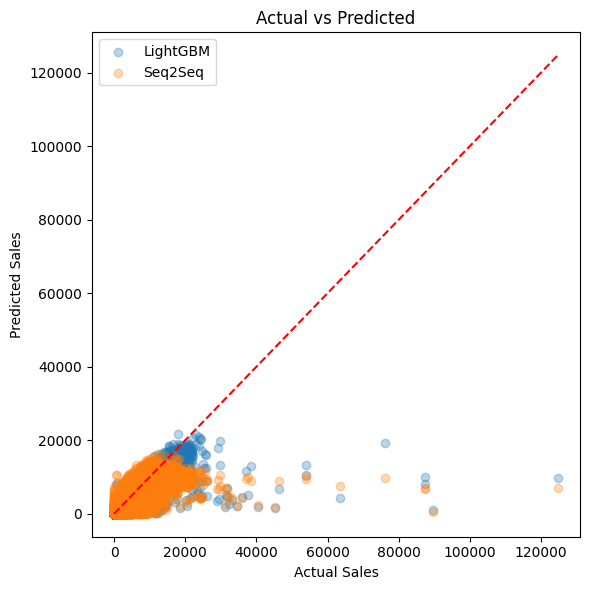

In [20]:
# Visualization Actual Vs Predicted

plt.figure(figsize=(6, 6))
plt.scatter(y_true_ml, y_pred_ml, alpha=0.3, label="LightGBM")
plt.scatter(y_true_dl, y_pred_dl, alpha=0.3, label="Seq2Seq")
plt.plot([0, y_true_ml.max()], [0, y_true_ml.max()], "r--")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.legend()
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()


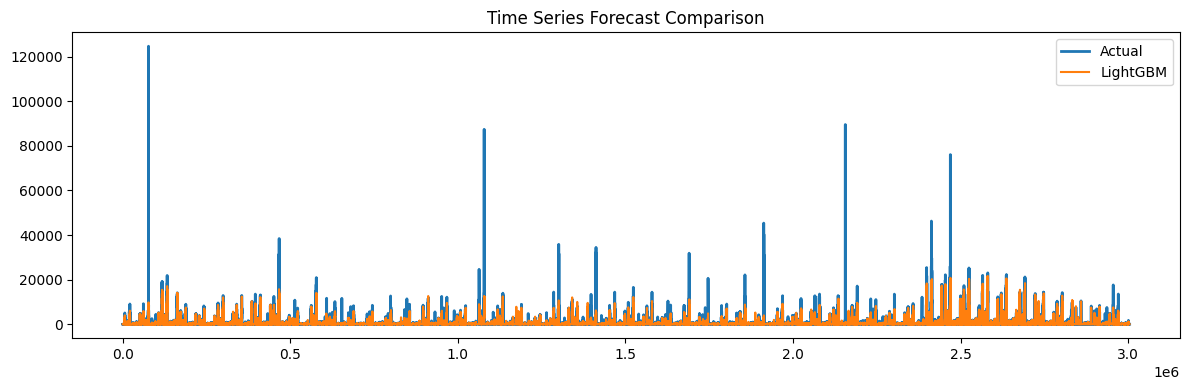

In [23]:
# Time Series Plot - ML Model

plt.figure(figsize=(12, 4))
plt.plot(y_true_ml, label="Actual", linewidth=2)
plt.plot(y_pred_ml, label="LightGBM")
plt.legend()
plt.title("Time Series Forecast Comparison")
plt.tight_layout()
plt.show()


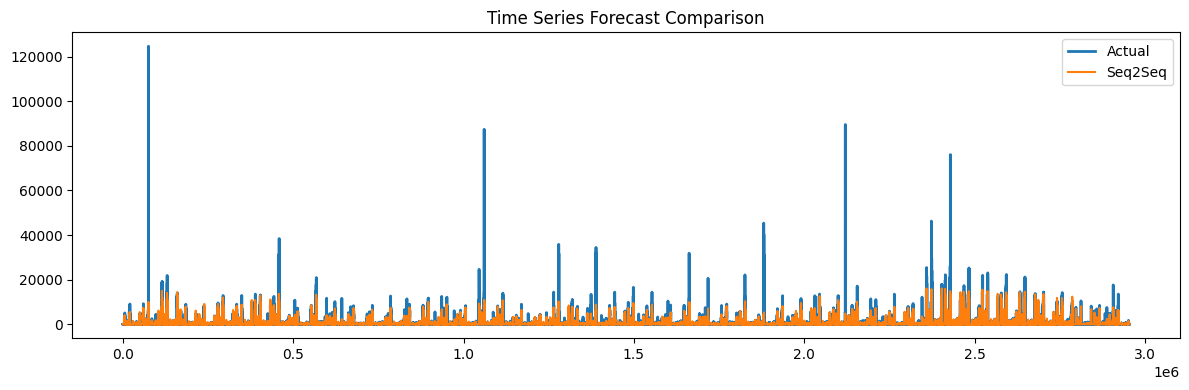

In [24]:
# Time Series Plot - DL Modle

plt.figure(figsize=(12, 4))
plt.plot(y_true_dl, label="Actual", linewidth=2)
plt.plot(y_pred_dl, label="Seq2Seq")
plt.legend()
plt.title("Time Series Forecast Comparison")
plt.tight_layout()
plt.show()


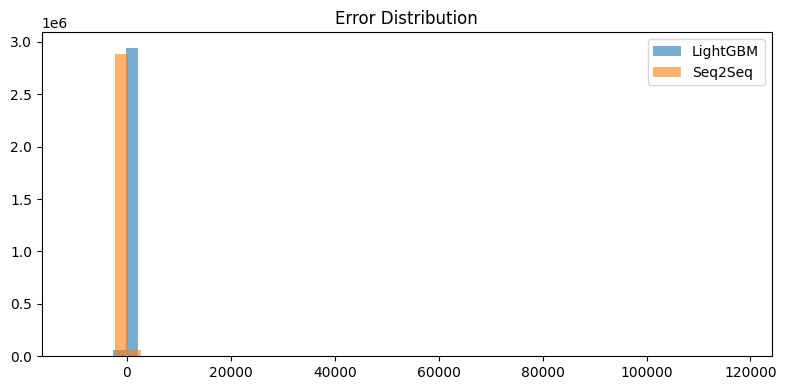

In [22]:
# Error Distribution
err_lgbm = y_true_ml - y_pred_ml
err_seq2seq = y_true_dl - y_pred_dl

plt.figure(figsize=(8, 4))
plt.hist(err_lgbm, bins=50, alpha=0.6, label="LightGBM")
plt.hist(err_seq2seq, bins=50, alpha=0.6, label="Seq2Seq")
plt.legend()
plt.title("Error Distribution")
plt.tight_layout()
plt.show()
